# Introduction

## Linear Regression

* Gradients were previously discussed in the context of the <b>gradient descent</b> algorithm for fitting linear regression models.

* For a regression model with $n$ parameters, it defines an $n+1$ dimensional space, encompassing all parameters and the cost/loss function.

* The combination of parameters and the loss function defines a <b>surface</b> within this space.

* Fitting the regression model involves descending along the steepest <i>downhill</i> gradient until the lowest (i.e., minimum) point of the surface is reached, where all possible gradients become <i>uphill</i>.

* The final model comprises the parameter estimates corresponding to that location on the surface.

## Gradient Boosting

> <b>NOTE:</b> Throughout all iterations of the gradient descent algorithm for <b>linear regression</b>, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function <i>never changes</i>. In <b>gradient boosting</b>, however, the underlying data <i>do change</i>.  

* In the Gradient Boosting, with each decision tree iteration, we extract the <b>residuals</b>.
A new decision tree is then run, using these residuals as the outcome to predict.

* After reaching a <b>stopping point</b>, we aggregate (i.e, sum) the predicted values from <i>all</i> decision trees to form the final gradient-boosted prediction.

* Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.

* Most commonly, gradient boosting uses decision trees, and minimizes either the  <b>residual (regression trees)</b> or the <b>negative log-likelihood (classification trees)</b> .  

# Dependencies

In [50]:
import re
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

%matplotlib inline

# Functions

## <code><b>plot_predictions</b></code>

In [51]:
def plot_predictions(
      regressors
    , X
    , y
    , axes
    , label      = None
    , style      = "r-"
    , data_style = "b."
    , data_label = None
  ):

    """
    Plot predictions made by regression models along with the actual data points.

    Parameters:
    - regressors (list of regressor objects): A list of regression models.
    - X (numpy.ndarray): Input feature(s) for making predictions.
    - y (numpy.ndarray): Actual target values.
    - axes (list or tuple of length 4): Axis limits for the plot in [xmin, xmax, ymin, ymax] format.
    - label (str, optional): Label for the predicted curve (for legend).
    - style (str, optional): Style of the predicted curve in the plot.
    - data_style (str, optional): Style of the data points in the plot.
    - data_label (str, optional): Label for the data points (for legend).

    Returns:
    None
    """

    x1 = np.linspace(
          axes[0]
        , axes[1]
        , 500
    )

    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1))
        for regressor
        in regressors
    )

    plt.plot(
          X[:, 0]
        , y
        , data_style
        , label = data_label
    )

    plt.plot(
          x1
        , y_pred
        , style
        , label     = label
        , linewidth = 2
    )

    if label or data_label:
        plt.legend(
              loc      = "upper center"
            , fontsize = 16
        )

    plt.axis(axes)

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Regression

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called <b>Gradient Tree Boosting</b>, or <b>Gradient Boosted Regression Trees</b>. First, let's fit a <code><b>DecisionTreeRegressor</b></code> to the training set.

## 1.1. Train/Test split (<code><b>X</b></code> and <code><b>y</b></code>)

In [53]:
np.random.seed(42)

# Features
X = np.random.rand(100, 1) - 0.5

In [54]:
# generate 100 random numbers from a standard normal distribution
# (mean = 0, standard deviation = 1) scaled by 0.05.  This introduces random
# variation to make the data more realistic and noisy.
random_noise = 0.05 * np.random.randn(100)

In [55]:
# Actual response
y = 3*X[:, 0]**2 + random_noise

In [56]:
X[:5], y[:5]

(array([[-0.12545988],
        [ 0.45071431],
        [ 0.23199394],
        [ 0.09865848],
        [-0.34398136]]),
 array([ 0.0515729 ,  0.59447979,  0.16605161, -0.07017796,  0.34398593]))

## 1.2. Regressor 1

In [57]:
reg_1 = DecisionTreeRegressor(
      max_depth    = 2
    , random_state = 42
)

In [58]:
reg_1.fit(
      X
    , y
)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [59]:
y_pred1 = reg_1.predict(X)

## 1.3. Regressor 2

Now train a second <code><b>DecisionTreeRegressor</b></code> on the residual errors made by the first predictor <code><b>reg_1</b></code> :

In [60]:
y_res1 = y - y_pred1

In [61]:
reg_2 = DecisionTreeRegressor(
      max_depth    = 2
    , random_state = 42
)

In [62]:
reg_2.fit(
      X
    , y_res1
)

DecisionTreeRegressor(max_depth=2, random_state=42)

## 1.4. Regressor 3

Then we train a third regressor on the residual errors made by the second predictor <code><b>reg_2</b></code> :



In [63]:
y_pred2 = reg_2.predict(X)

In [64]:
y_res2 = y_res1 - y_pred2

In [65]:
reg_3 = DecisionTreeRegressor(
      max_depth    = 2
    , random_state = 42
)

In [66]:
reg_3.fit(
      X
    , y_res2
)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [67]:
X_new = np.array([[0.8]])

In [68]:
y_pred = sum(
    tree.predict(X_new)
    for tree
    in (reg_1, reg_2, reg_3)
)

In [69]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

## 1.5. Plot predictions

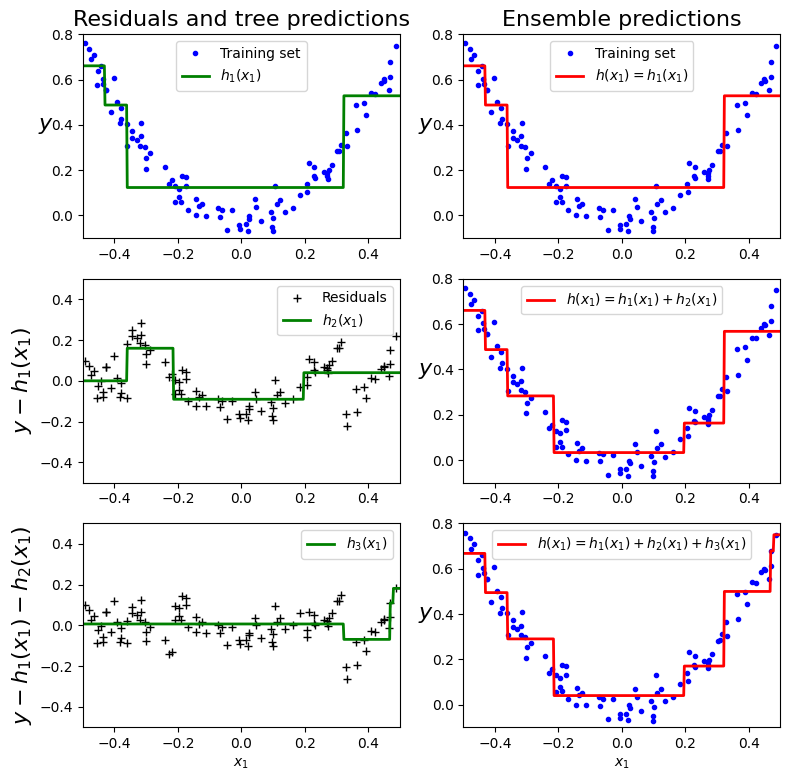

In [70]:
mpl.rcParams['axes.titlesize']  = 16
mpl.rcParams['ytick.labelsize'] = 10
fontsize_legends                = 10
# -----------------------------------------------------------------------------
plt.figure(figsize=(9, 9))
# -----------------------------------------------------------------------------
#                               SUBPLOT 321
# -----------------------------------------------------------------------------
ax321 = plt.subplot(321)

plot_predictions(
      [reg_1]
    , X
    , y
    , axes       = [-0.5, 0.5, -0.1, 0.8]
    , label      = "$h_1(x_1)$"
    , style      = "g-"
    , data_label = "Training set"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
    , rotation = 0
)

plt.title(
      "Residuals and tree predictions"
    , fontsize = 16
)

ax321.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 322
# -----------------------------------------------------------------------------
ax322 = plt.subplot(322)

plot_predictions(
      [reg_1]
    , X
    , y
    , axes       = [-0.5, 0.5, -0.1, 0.8]
    , label      = "$h(x_1) = h_1(x_1)$"
    , data_label = "Training set"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
    , rotation = 0
)

plt.title(
      "Ensemble predictions"
)

ax322.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 323
# -----------------------------------------------------------------------------
ax323 = plt.subplot(323)

plot_predictions(
      [reg_2]
    , X
    , y_res1
    , axes       = [-0.5, 0.5, -0.5, 0.5]
    , label      = "$h_2(x_1)$"
    , style      = "g-"
    , data_style = "k+"
    , data_label = "Residuals"
)

plt.ylabel(
      "$y - h_1(x_1)$"
    , fontsize = 16
)

ax323.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 324
# -----------------------------------------------------------------------------
ax324 = plt.subplot(324)

plot_predictions(
    [reg_1, reg_2]
    , X
    , y
    , axes  = [-0.5, 0.5, -0.1, 0.8]
    , label = "$h(x_1) = h_1(x_1) + h_2(x_1)$"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
    , rotation = 0
)

ax324.legend(
      fontsize = fontsize_legends
)# -----------------------------------------------------------------------------
#                               SUBPLOT 325
# -----------------------------------------------------------------------------
ax325 = plt.subplot(325)

plot_predictions(
      [reg_3]
    , X
    , y_res2
    , axes       = [-0.5, 0.5, -0.5, 0.5]
    , label      = "$h_3(x_1)$"
    , style      = "g-"
    , data_style = "k+"
)

plt.xlabel(
      "$x_1$"
)

plt.ylabel(
      "$y - h_1(x_1) - h_2(x_1)$"
    , fontsize = 16
)

ax325.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#                               SUBPLOT 326
# -----------------------------------------------------------------------------
ax326 = plt.subplot(326)

plot_predictions(
      [reg_1, reg_2, reg_3]
    , X
    , y
    , axes  = [-0.5, 0.5, -0.1, 0.8]
    , label = "$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$"
)

plt.xlabel(
      "$x_1$"
)

plt.ylabel(
      "$y$"
    , fontsize = 16
    , rotation = 0
)

ax326.legend(
      fontsize = fontsize_legends
)
# -----------------------------------------------------------------------------
#save_fig("gradient_boosting_plot")
plt.show()

# 2. Classification

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

## 2.1. Load data

Use pandas <code><b>read_csv()</b></code> method to load in the Titantic data set into a dataframe object called <code><b>df</b></code> .

> <b>Hint:</b> In this case, you can use <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html"><code><b>dropna()</b></code></a> to just throw away any incomplete rows. For the purpose of this exercise, we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations.

In [23]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/data/14.5.titanic.csv"
).dropna()

## 2.2. Visualize

In [24]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


Print the levels of the categorical data using <code><b>select_dtypes()</b></code> .

In [26]:
# Select columns of dtype 'object'
df_cols_obj = df.select_dtypes(
    include = ['object']
)

In [27]:
# Loop through the selected categorical columns and print unique levels
for col in df_cols_obj.columns:

    unique_levels = df_cols_obj[col].unique()

    # Prettify the output
    print(f"Unique levels in feature '{col}':")
    for unique_level in unique_levels:
        print(f"  - {unique_level}")

Unique levels in feature 'Name':
  - Cumings, Mrs. John Bradley (Florence Briggs Thayer)
  - Futrelle, Mrs. Jacques Heath (Lily May Peel)
  - McCarthy, Mr. Timothy J
  - Sandstrom, Miss. Marguerite Rut
  - Bonnell, Miss. Elizabeth
  - Beesley, Mr. Lawrence
  - Sloper, Mr. William Thompson
  - Fortune, Mr. Charles Alexander
  - Harper, Mrs. Henry Sleeper (Myna Haxtun)
  - Ostby, Mr. Engelhart Cornelius
  - Harris, Mr. Henry Birkhardt
  - Nye, Mrs. (Elizabeth Ramell)
  - Moen, Mr. Sigurd Hansen
  - Fortune, Miss. Mabel Helen
  - Chaffee, Mr. Herbert Fuller
  - Goldschmidt, Mr. George B
  - Greenfield, Mr. William Bertram
  - White, Mr. Richard Frasar
  - Porter, Mr. Walter Chamberlain
  - Baxter, Mr. Quigg Edmond
  - Webber, Miss. Susan
  - White, Mr. Percival Wayland
  - Newsom, Miss. Helen Monypeny
  - Futrelle, Mr. Jacques Heath
  - Giglio, Mr. Victor
  - Navratil, Mr. Michel ("Louis M Hoffman")
  - Pears, Mrs. Thomas (Edith Wearne)
  - Van der hoef, Mr. Wyckoff
  - Smith, Mr. James C

## 2.3. Feature Engineering

Create dummy features for the categorical features and add those to the dataframe <code><b>df</b></code> . Make sure to also remove the original categorical columns from the <code><b>df</b></code> .

In [28]:
try:
  df = df.drop(df_cols_obj.columns, axis=1)\
      .join(pd.get_dummies(df_cols_obj.drop(['Name', 'Cabin', 'Ticket'], axis=1)))\
      .drop('PassengerId', axis=1)
except:
  pass

In [29]:
df.shape

(183, 11)

In [30]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
6,0,1,54.0,0,0,51.8625,0,1,0,0,1
10,1,3,4.0,1,1,16.7000,1,0,0,0,1
11,1,1,58.0,0,0,26.5500,1,0,0,0,1


Print the null values for each column in the dataframe <code><b>df</b></code> .

In [31]:
df.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

## 2.4. Features and Target variable

Create the <code><b>X</b></code> and <code><b>y</b></code> matrices from the dataframe <code><b>df</b></code>, where <code><b>y = df.Survived</b></code> .

In [32]:
y = df["Survived"]

In [33]:
X = df.drop(
      'Survived'
    , axis = 1
)

## 2.5. Feature scaling

Apply the <code><b>StandardScaler()</b></code> to the <code><b>X</b></code> matrix.

In [34]:
X_scaled = preprocessing\
          .StandardScaler()\
          .fit_transform(X)

## 2.6. Train/Test split (<code><b>X</b></code> and <code><b>y</b></code>)

Split the <code><b>X_scaled</b></code> and <code><b>y</b></code> into $75/25$ training and testing data subsets.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
      X_scaled
    , y
    , train_size   = 0.75
    , random_state = 1
)

## 2.7. Find the best Learning Rate

Run the cell below to test multiple learning rates in your <code><b>GradientBoostingClassifier</b></code> .

In [36]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

best_learning_rate       = None
best_validation_accuracy = 0

for learning_rate in learning_rates:

    gb = GradientBoostingClassifier(
          n_estimators  = 20
        , learning_rate = learning_rate
        , max_features  = 2
        , max_depth     = 2
        , random_state  = 0
    )

    gb.fit(
          X_train
        , y_train
    )

    training_accuracy = gb.score(
          X_train
        , y_train
    )

    validation_accuracy = gb.score(
          X_test
        , y_test
    )

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

    # Check if the current model has the best validation accuracy
    if validation_accuracy > best_validation_accuracy:
        best_learning_rate       = learning_rate
        best_validation_accuracy = validation_accuracy

Learning rate:  0.05
Accuracy score (training): 0.715
Accuracy score (validation): 0.652

Learning rate:  0.1
Accuracy score (training): 0.847
Accuracy score (validation): 0.739

Learning rate:  0.25
Accuracy score (training): 0.876
Accuracy score (validation): 0.739

Learning rate:  0.5
Accuracy score (training): 0.898
Accuracy score (validation): 0.739

Learning rate:  0.75
Accuracy score (training): 0.905
Accuracy score (validation): 0.761

Learning rate:  1
Accuracy score (training): 0.912
Accuracy score (validation): 0.696



> <b>NOTE:</b> The best learning rate is the one that resulted in the highest validation accuracy. In our case, the <code><b>Learning rate = 0.75</b></code> achieved the highest validation accuracy, i.e., <code><b>Accuracy score (validation) = 0.761</b></code> .

In [37]:
print("Best Learning Rate:", best_learning_rate)
print("Best Validation Accuracy:", round(best_validation_accuracy, 3))

Best Learning Rate: 0.75
Best Validation Accuracy: 0.761


## 2.8. Build

1. Build (initialize) a <code><b>GradientBoostingClassifier</b></code> model with the <code><b>best_learning_rate</b></code> .
2. <code><b>fit</b></code> the model on the training data <code><b>(X_train, y_train)</b></code> .
3. <code><b>predict</b></code> on the testing set <code><b>(X_test, y_test)</b></code> .
4. Plot the confusion matrix for <code><b>(y_test, y_pred)</b></code> .
5. Print out the classification report for <code><b>(y_test, y_pred)</b></code> to review the model performance.

In [38]:
# Initialize the model with the best learning rate
best_gb = GradientBoostingClassifier(
      n_estimators  = 20
    , max_features  = 2
    , max_depth     = 2
    , random_state  = 0
    , learning_rate = best_learning_rate
)

## 2.9. Fit

In [39]:
# Fit on the training data
best_gb.fit(
      X_train
    , y_train
)

GradientBoostingClassifier(learning_rate=0.75, max_depth=2, max_features=2,
                           n_estimators=20, random_state=0)

## 2.10. Predict

In [40]:
# Predict on the testing set
y_pred = best_gb.predict(
    X_test
)

## 2.11. Confusion matrix

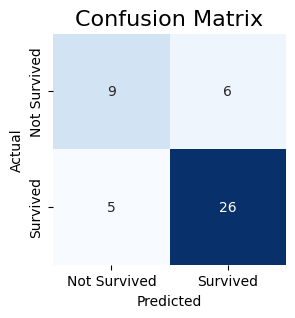

In [41]:
# Calculate the confusion matrix
cm = confusion_matrix(
      y_test
    , y_pred
)

# Define the class labels (0: Not survived, 1: Survived)
class_labels = [
      'Not Survived'
    , 'Survived'
]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(3, 3))

sns.heatmap(
      cm
    , fmt         = 'd'
    , annot       = True
    , cmap        = 'Blues'
    , cbar        = False
    , xticklabels = class_labels
    , yticklabels = class_labels
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 2.12. Classification report

In [42]:
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.81      0.84      0.83        31

    accuracy                           0.76        46
   macro avg       0.73      0.72      0.72        46
weighted avg       0.76      0.76      0.76        46



## 2.13. ROC curve

Calculate the ROC for the model as well. To do this end, we:

1. Calculate the predicted probabilities for class 1 (Survived) using <code><b>predict_proba</b></code> .

2. Use the <code><b>roc_curve</b></code> function to compute the ROC curve, which returns the false positive rate (fpr), true positive rate (tpr), and thresholds.

3. Calculate the AUC (Area Under the ROC Curve) using the <code><b>roc_auc_score</b></code> function.

In [43]:
# Calculate the predicted probabilities for class 1 (Survived)
y_prob = best_gb\
         .predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(
      y_test
    , y_prob
)

# AUC
roc_auc = roc_auc_score(
      y_test
    , y_prob
)

## 2.14. Plot ROC curve

This code will generate and display the <b>ROC curve</b> for the model, along with the <b>AUC score</b>, allowing us to assess the model's performance in terms of classification thresholds and the trade-off between true positives and false positives.

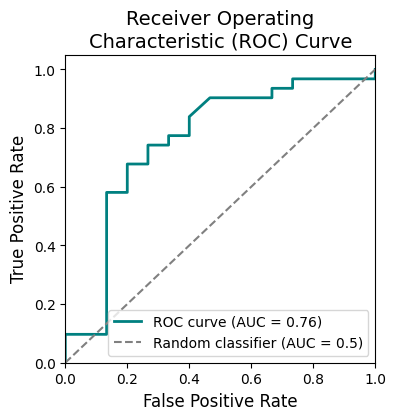

In [48]:
plt.figure(figsize=(4, 4))
# -----------------------------------------------------------------------------
# ROC curve
plt.plot(
      fpr
    , tpr
    , color = 'teal'
    , label = f'ROC curve (AUC = {roc_auc:.2f})'
    , lw    = 2
)
# -----------------------------------------------------------------------------
# Random classifier (AUC = 0.5) as the baseline
plt.plot(
      [0, 1]
    , [0, 1]
    , color     = 'gray'
    , label     = 'Random classifier (AUC = 0.5)'
    , linestyle = '--'
)
# -----------------------------------------------------------------------------
plt.xlim(
    [0.0, 1.00]
)

plt.ylim(
    [0.0, 1.05]
)
# -----------------------------------------------------------------------------
plt.xlabel(
      'False Positive Rate'
    , fontsize = 12
)

plt.ylabel(
      'True Positive Rate'
    , fontsize = 12
)
# -----------------------------------------------------------------------------
plt.title(
      'Receiver Operating\nCharacteristic (ROC) Curve'
    , fontsize = 14
)

plt.legend(
    loc='best'
)
# -----------------------------------------------------------------------------
plt.show()